# DSSE Project: Flood prediction based on weather factors
In this project we attempted to predict floods in the Betuwe area of Netherlands based on the weather in the Swiss alps.
Although my code was not used in the group project submission, I present it here. Each code block contributes to a specific learning goal as indicated below. The comments further explain what each part of the code does.

## Overview of Methodology
__Step 1__: We identified the region from where weather factors need to be taken. My groupmates identified this region based on various research papers which had researched the origin of the river - Rhine. My groupmates then generated random points within this region (polygon) using the "Random points inside polygon" tool in QGIS. The region and the locations of weather inputs is shown below. The image was generated using QGIS.
![Weather Input Locations](img1_SwissAlpsRegion.png)

__Step 2__: I used the locations to gather historical data on various weather factors that are available on open-meteo (https://open-meteo.com/en/docs/historical-weather-api). I obtained 5 years of daily values of these weather factors in the 10 locations. The values were recorded every day.
![Historical Weather Sample](img2_historicalWeather.png)

__Step 3__: We defined flood risk as the water depth in the Betuwe region. Specifically, I considered the water depth in the Grebbe waterpunt and Dodewaard waterpunt. From the Rijkswaterstaat website (https://waterinfo.rws.nl/), I made a request to download 5 years of data on water depth at these two points. The values were recorded every 10 minutes.
![Historical Water Sample](img3_historicalWaterDepth.png)

__Step 4__: After checking the data for absurd values, I flattened the water depth data (by taking the highest water depth of the day as the daily value) and merged it with the weather data according to date. I made changes to the date column and other columns according to what is required by a Long Short-Term Memory (LSTM) recurrent neural network (RNN) model.

__Step 5__: I trained two LSTM RNN models. The resulting models can predict tomorrow's highest water depth at Grebbe and Dodewaard based on the past 60 days of weather data from the same locations (in the Swiss alps) with a validation loss (root mean squared error) of about 0.0005 in the last epoch.

__Step 6__: I downloaded the last 60 days of weather data in the same 10 locations and used the model to predict tomorrow's water depth at Grebbe and Dodewaard.

__Step 7__: I used folium to visualise these water depths at the two locations on an interactive map. I included the same UI elements as the Rijkwaterstaat website (https://waterinfo.rws.nl/).

## Detailed Methodology

### Dependencies (pip install all these libraries)
- openmeteo_requests
- requests_cache
- pandas
- retry_requests
- IPython.display
- matplotlib
- seaborn
- numpy
- datetime
- sklearn
- tensorflow
- joblib
- logging
- os
- sys
- tarfile
- requests
- folium
- branca
- xarray
- pygrib

### Acquire historical weather data from Open-meteo (Step 2)
__Code block function:__ This code block fetches the values of specified weather factors from specified locations for a specified number of days from open-meteo API service. It downloads the data onto a specified directory as a CSV file.

__Contribution to Goal 2:__ I obtained the base code from the open-meteo website (https://open-meteo.com/en/docs/historical-weather-api). However, I had to make some changes to it such that it obtains data from a list of locations. Understanding the code helped me understand how we can interact with the api and its responses using Python. I learnt that the response is usually an object and its components can be referred to like a multi-dimensional array. For example: objectname[0][0].

In [45]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Function to process daily data for one location
def process_location_data(response):
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")
    
    daily = response.Daily()
    daily_data = {
        "date": pd.date_range(
            start=pd.to_datetime(daily.Time(), unit="s", utc=True),
            end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=daily.Interval()),
            inclusive="left"
        ),
        "temperature_2m_mean": daily.Variables(0).ValuesAsNumpy(),
        "daylight_duration": daily.Variables(1).ValuesAsNumpy(),
        "sunshine_duration": daily.Variables(2).ValuesAsNumpy(),
        "precipitation_sum": daily.Variables(3).ValuesAsNumpy(),
        "precipitation_hours": daily.Variables(4).ValuesAsNumpy(),
        "wind_speed_10m_max": daily.Variables(5).ValuesAsNumpy(),
        "wind_direction_10m_dominant": daily.Variables(6).ValuesAsNumpy(),
        "shortwave_radiation_sum": daily.Variables(7).ValuesAsNumpy()
    }
    return pd.DataFrame(data=daily_data)

# List of locations to fetch data for (latitude, longitude)
locations = [
    {"latitude": 47.0148862689, "longitude": 9.2490818321},  
    {"latitude": 48.0561013408, "longitude": 9.5514402618},  
    {"latitude": 47.9734825136, "longitude": 8.7353165590}, 
    {"latitude": 47.5598803131, "longitude": 7.7607424907},
    {"latitude": 47.2781227972, "longitude": 8.1218956317},
    {"latitude": 47.8954308927, "longitude": 8.3057342889},
    {"latitude": 47.9342963251, "longitude": 8.1956883139},
    {"latitude": 48.0649760121, "longitude": 8.9797479456},
    {"latitude": 47.8700339813, "longitude": 9.2892803863},
    {"latitude": 47.3828032700, "longitude": 8.1122011127}, 
]

# Make API calls and process data for all locations
all_dataframes = []

for location in locations:
    params = {
        "latitude": location["latitude"],
        "longitude": location["longitude"],
        "start_date": "2020-01-01",                                             # change the start date for the data acquisition here
        "end_date": "2025-01-01",                                               # change the end date for the data acquisition here
        "daily": [
            "temperature_2m_mean", "daylight_duration", "sunshine_duration", 
            "precipitation_sum", "precipitation_hours", "wind_speed_10m_max", 
            "wind_direction_10m_dominant", "shortwave_radiation_sum"
        ],
        "timezone": "auto"  # Automatically fetch timezone based on location
    }
    responses = openmeteo.weather_api("https://archive-api.open-meteo.com/v1/archive", params=params)
    response = responses[0]
    location_data = process_location_data(response)
    location_data["location"] = f"{location['latitude']},{location['longitude']}"  # Add location info
    all_dataframes.append(location_data)

# Combine all dataframes into one
combined_dataframe = pd.concat(all_dataframes, ignore_index=True)

# Output the combined dataframe
print(combined_dataframe.head())

# Download the data as a csv file
output_filename = "2020-2025_HistoricalWeather_OpenMeteo.csv"
combined_dataframe.to_csv(output_filename, index=False)
from IPython.display import FileLink
FileLink(output_filename)

Coordinates 46.99472427368164°N 9.204545021057129°E
Elevation 2151.0 m asl
Timezone b'Europe/Zurich' b'GMT+1'
Timezone difference to GMT+0 3600 s
Coordinates 48.0492057800293°N 9.584026336669922°E
Elevation 605.0 m asl
Timezone b'Europe/Berlin' b'GMT+1'
Timezone difference to GMT+0 3600 s
Coordinates 47.97890853881836°N 8.820598602294922°E
Elevation 880.0 m asl
Timezone b'Europe/Berlin' b'GMT+1'
Timezone difference to GMT+0 3600 s
Coordinates 47.5571174621582°N 7.697368621826172°E
Elevation 279.0 m asl
Timezone b'Europe/Berlin' b'GMT+1'
Timezone difference to GMT+0 3600 s
Coordinates 47.27592086791992°N 8.235294342041016°E
Elevation 687.0 m asl
Timezone b'Europe/Zurich' b'GMT+1'
Timezone difference to GMT+0 3600 s
Coordinates 47.90861129760742°N 8.358208656311035°E
Elevation 841.0 m asl
Timezone b'Europe/Berlin' b'GMT+1'
Timezone difference to GMT+0 3600 s
Coordinates 47.90861129760742°N 8.358208656311035°E
Elevation 859.0 m asl
Timezone b'Europe/Berlin' b'GMT+1'
Timezone difference to

### Wrangle and clean water depth data (Step 4)
__Code block function:__ This code block reads the historical water depth CSV file, removes the outliers, plots a boxplot and histogram of water depths and flattens the values (from every 10 minutes) into daily values. For flattening, it takes the highest water depth recorded in that particular day. It returns two separate dataframes - one with water depths of Grebbe and one with water depths of Dodewaard.

__Contribution to Goal 2:__ I had to understand how the data is distributed so I learnt how to create plots using Python. I used the matplotlib and seaborn libraries to create plots. I identified the outliers to be outside values crossing (4 * IQR) on either side of the quantiles. The outliers were probably missing records marked as 999999999. I dropped these rows so that it does not interfere with the maximum values of water depth taken in the day. It was a bit complicated to assign the respective dates and drop the datetimes. Through this block I learnt about plotting and identifying outliers/mistakes in the data.

count    5.264660e+05
mean     7.755629e+05
std      2.782766e+07
min      2.790000e+02
25%      5.240000e+02
50%      6.070000e+02
75%      6.260000e+02
max      1.000000e+09
Name: NUMERIC VALUE, dtype: float64


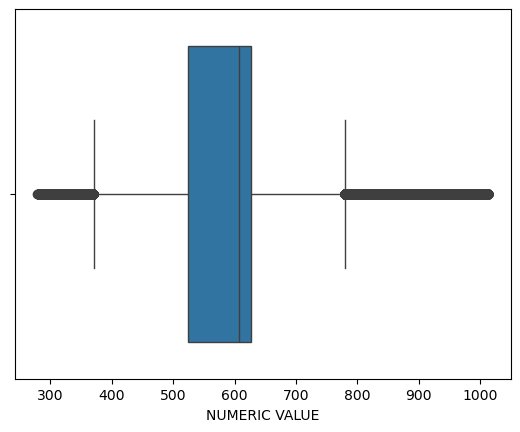

Number of outliers dropped: 408
Outliers dropped:
[999999999]


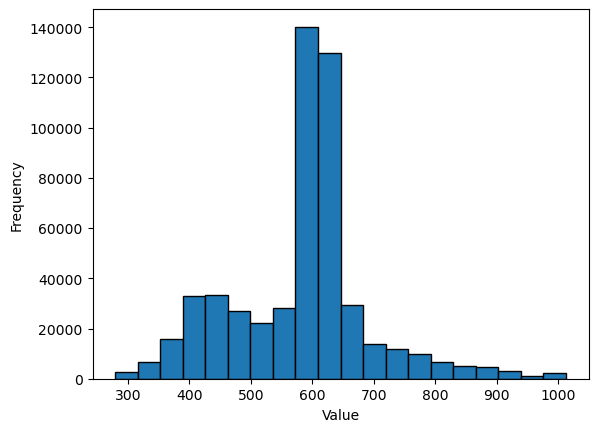

Total count of values above 900 (excluding outliers): 6663
Dodewaard Flattened Data:
   SAMPLE_IDENTIFICATION MEASUREMENT_POINT_IDENTIFICATION LOCATION_CODE  \
0                    NaN                        Dodewaard         DODWD   
1                    NaN                        Dodewaard         DODWD   
2                    NaN                        Dodewaard         DODWD   
3                    NaN                        Dodewaard         DODWD   
4                    NaN                        Dodewaard         DODWD   

   TYPE_DESCRIPTION  TYPE_CODE SIZE_DESCRIPTION SIZE_CODE  \
0               NaN        NaN      Waterhoogte    WATHTE   
1               NaN        NaN      Waterhoogte    WATHTE   
2               NaN        NaN      Waterhoogte    WATHTE   
3               NaN        NaN      Waterhoogte    WATHTE   
4               NaN        NaN      Waterhoogte    WATHTE   

   PARAMETER_DESCRIPTION  PARAMETER_CODE  CAS_NR  ...   Y ORGAN_DESCRIPTION  \
0                 

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Read the input CSV files of the historical data that will be used to train the model
waterdepth_data = pd.read_csv('WorkingWaterDepth.csv')

# Summary of the water depth numeric values
print(waterdepth_data['NUMERIC VALUE'].describe())

# Build IQR of the water depth values
Q1 = waterdepth_data['NUMERIC VALUE'].quantile(0.25)
Q3 = waterdepth_data['NUMERIC VALUE'].quantile(0.75)
IQR = Q3 - Q1

# Filter out rows where the outliers are contained
waterdepth_data_no_outliers = waterdepth_data[(waterdepth_data['NUMERIC VALUE'] >= (Q1 - 4 * IQR)) & 
                                              (waterdepth_data['NUMERIC VALUE'] <= (Q3 + 4 * IQR))]

# Check the new distribution
sns.boxplot(x=waterdepth_data_no_outliers['NUMERIC VALUE'])
plt.show()

outliers = waterdepth_data[~waterdepth_data.index.isin(waterdepth_data_no_outliers.index)]

# Print the number of outliers dropped
outliers_dropped = len(outliers)
print(f"Number of outliers dropped: {outliers_dropped}")

# Print the unique list of outliers
print("Outliers dropped:")
print(outliers['NUMERIC VALUE'].unique())

# plot the remaining values on a histogram
waterdepth_data_no_outliers['NUMERIC VALUE'].plot(kind='hist', bins=20, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Show the count of values which are above a certain value (900cm is the "high" water depth)
count_above_900 = len(waterdepth_data_no_outliers[waterdepth_data_no_outliers['NUMERIC VALUE'] > 900])
print(f"Total count of values above 900 (excluding outliers): {count_above_900}")

# Filter data for the two stations
dodewaard_water = waterdepth_data_no_outliers[waterdepth_data_no_outliers['MEASUREMENT_POINT_IDENTIFICATION'] == 'Dodewaard']
grebbe_water = waterdepth_data_no_outliers[waterdepth_data_no_outliers['MEASUREMENT_POINT_IDENTIFICATION'] == 'Grebbe']
# print(f"Data for Dodewaard: {len(dodewaard_water)} rows")
# print(f"Data for Grebbe: {len(grebbe_water)} rows")

### FLATTEN INTO DAILY OBSERVATIONS ###
# Ensure we are working with a fresh copy of the DataFrame
dodewaard_water = dodewaard_water.copy()
grebbe_water = grebbe_water.copy()

# Combine 'OBSERVATION_DATE' and 'OBSERVATION_TIME (MET/CET)' into a datetime column using .loc
dodewaard_water['datetime'] = pd.to_datetime(
    dodewaard_water['OBSERVATION_DATE'] + ' ' + dodewaard_water['OBSERVATION_TIME (MET/CET)'], 
    format='%d-%m-%Y %H:%M:%S'
)
grebbe_water['datetime'] = pd.to_datetime(
    grebbe_water['OBSERVATION_DATE'] + ' ' + grebbe_water['OBSERVATION_TIME (MET/CET)'], 
    format='%d-%m-%Y %H:%M:%S'
)

# Extract just the date from the datetime column using .loc
dodewaard_water['date'] = dodewaard_water['datetime'].dt.date
grebbe_water['date'] = grebbe_water['datetime'].dt.date

# Group by 'date' and find the row with the maximum water depth for each day
dodewaard_flattened = dodewaard_water.loc[dodewaard_water.groupby('date')['NUMERIC VALUE'].idxmax()].reset_index(drop=True)
grebbe_flattened = grebbe_water.loc[grebbe_water.groupby('date')['NUMERIC VALUE'].idxmax()].reset_index(drop=True)

# Check the results
print("Dodewaard Flattened Data:")
print(dodewaard_flattened.head())

print("\nGrebbe Flattened Data:")
print(grebbe_flattened.head())

### Understand trends of weather data (Step 4)
__Code block function:__ This code block reads the historical weather data CSV file, plots the distribution and boxplots of weather factor values.

__Contribution to Goal 2:__ The learnings from this block were similar to the learnings from the code block on cleaning of water depth data. However, in this case, there was no need to clean because there were no absurd values in the data. Through this block I learnt how to plot continuous distribution for multiple columns together using seaborn.


Columns:
Index(['date', 'temperature_2m_mean', 'daylight_duration', 'sunshine_duration',
       'precipitation_sum', 'precipitation_hours', 'wind_speed_10m_max',
       'wind_direction_10m_dominant', 'shortwave_radiation_sum', 'location'],
      dtype='object')

Summary Statistics:
       temperature_2m_mean  daylight_duration  sunshine_duration  \
count         18280.000000       18280.000000       18280.000000   
mean              8.466222       44061.448844       28303.246338   
std               7.752625        9348.755494       15882.397726   
min             -20.439750       30098.406000           0.000000   
25%               2.588104       35045.104750       16694.290250   
50%               8.209958       44179.429000       29841.383000   
75%              14.804375       53096.593000       41686.932500   
max              28.504251       57791.330000       53432.260000   

       precipitation_sum  precipitation_hours  wind_speed_10m_max  \
count       18280.000000         1

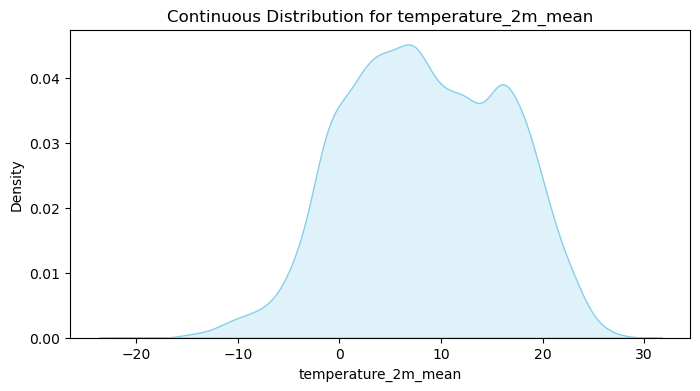

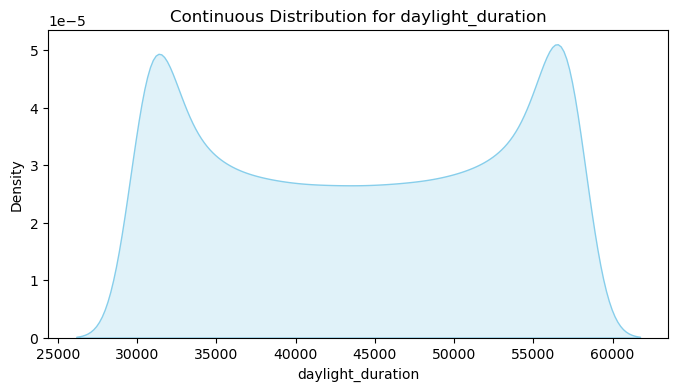

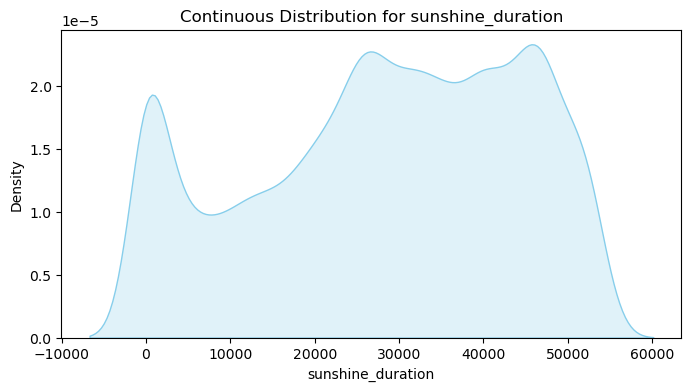

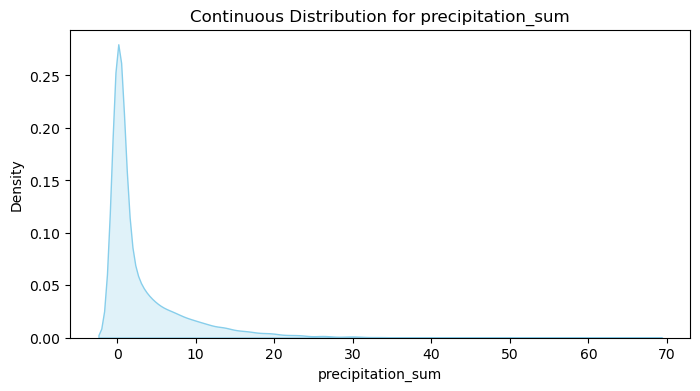

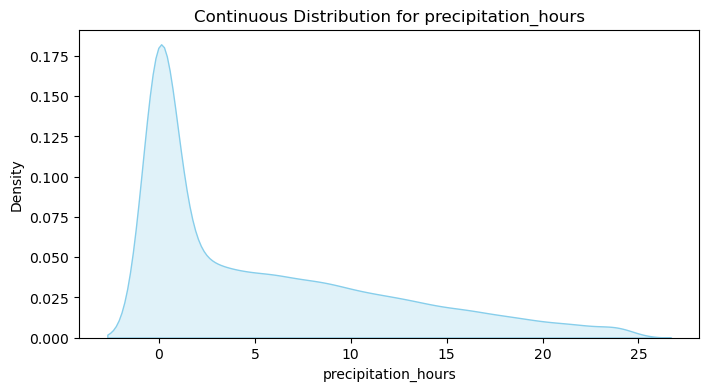

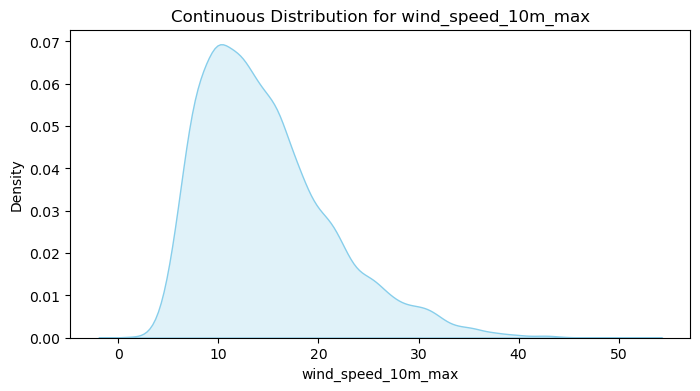

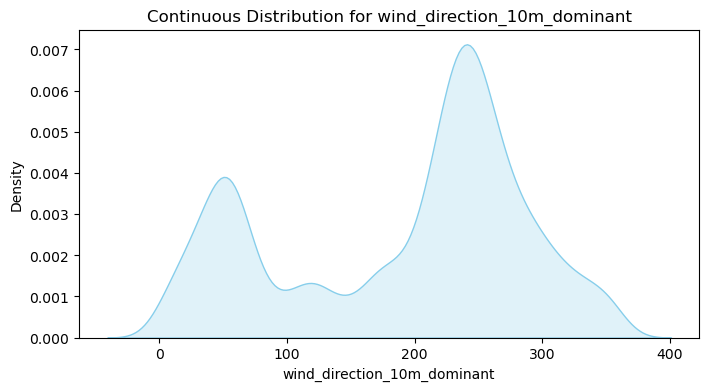

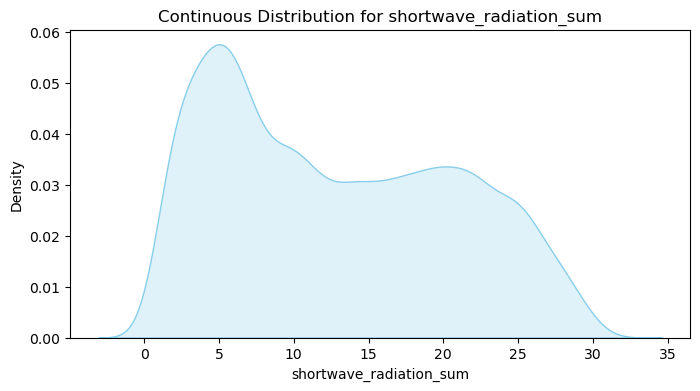

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the input CSV files of the historical data that will be used to train the model
weather_data = pd.read_csv('WorkingWeather.csv')

print("\nColumns:")
print(weather_data.columns)
print("\nSummary Statistics:")
print(weather_data.describe())

# Step 3: Visualize distributions to check for outliers
numeric_columns = weather_data.select_dtypes(include=['float64', 'int64']).columns

# Boxplots for all numeric columns
for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=weather_data[column].dropna(), fill=True, color='skyblue')
    plt.title(f"Continuous Distribution for {column}")
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.show()

### Preparing data for Long short-term memory (LSTM) recurrent neural network (RNN) model (Step 4)
__Code block function:__ This block merges the weather data with the water depth data based on date, creates new columns which are useful for LSTMs to understand the cyclic nature of dates. It then drops the unnecessary columns. You can choose which water depth to predict in this code block - grebbe_flattened or dodewaard_flattened.

__Contribution to Goal 2:__ This contributes to data wrangling and preparation goals because I learnt how to merge the data. I also learnt that LSTM models prefer cyclic features (from conversations with people who have used LSTMs - for example, Aditi). So using chatgpt, I learnt how to convert normal dates into cyclic features and added this to the dataframe. I also learnt to ensure that all the columns are in some numerical format so that they can be input into an LSTM training.

In [71]:
weather_data['new_date'] = (pd.to_datetime(weather_data['date']) + pd.Timedelta(hours=1)).dt.date
#print(weather_data['new_date'])
#print(grebbe_flattened['date'])

water_depth_data = dodewaard_flattened[['date', 'NUMERIC VALUE']]                   #------------------------ change to dodewaard_flattened to predict for dodewaard water depth

merged_data = pd.merge(weather_data, water_depth_data, left_on='new_date', right_on='date', how='left')

# Ensure 'new_date' is in datetime format
merged_data['new_date'] = pd.to_datetime(merged_data['new_date'])

# Extract useful date-related features
merged_data['year'] = merged_data['new_date'].dt.year
merged_data['month'] = merged_data['new_date'].dt.month  # 1 to 12
merged_data['day'] = merged_data['new_date'].dt.day  # 1 to 31
merged_data['weekday'] = merged_data['new_date'].dt.weekday  # Monday=0, Sunday=6
merged_data['day_of_year'] = merged_data['new_date'].dt.dayofyear  # 1 to 365/366

# Drop the original date column (LSTM doesn't work with raw dates)
merged_data = merged_data.drop(columns=['new_date'])

import numpy as np

# Encode cyclic features
merged_data['month_sin'] = np.sin(2 * np.pi * merged_data['month'] / 12)
merged_data['month_cos'] = np.cos(2 * np.pi * merged_data['month'] / 12)

merged_data['day_sin'] = np.sin(2 * np.pi * merged_data['day'] / 31)
merged_data['day_cos'] = np.cos(2 * np.pi * merged_data['day'] / 31)

merged_data['weekday_sin'] = np.sin(2 * np.pi * merged_data['weekday'] / 7)
merged_data['weekday_cos'] = np.cos(2 * np.pi * merged_data['weekday'] / 7)

merged_data[['latitude', 'longitude']] = (merged_data['location'].str.split(',', expand=True)).astype(float)

merged_data['water_depth'] = merged_data['NUMERIC VALUE']

# Drop unnecessary columns
merged_data = merged_data.drop(columns=['month', 'day', 'weekday','date_x','location', 'date_y','NUMERIC VALUE'])

print(merged_data.columns)
print(merged_data.dtypes)

Index(['temperature_2m_mean', 'daylight_duration', 'sunshine_duration',
       'precipitation_sum', 'precipitation_hours', 'wind_speed_10m_max',
       'wind_direction_10m_dominant', 'shortwave_radiation_sum', 'year',
       'day_of_year', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'weekday_sin', 'weekday_cos', 'latitude', 'longitude', 'water_depth'],
      dtype='object')
temperature_2m_mean            float64
daylight_duration              float64
sunshine_duration              float64
precipitation_sum              float64
precipitation_hours            float64
wind_speed_10m_max             float64
wind_direction_10m_dominant    float64
shortwave_radiation_sum        float64
year                             int32
day_of_year                      int32
month_sin                      float64
month_cos                      float64
day_sin                        float64
day_cos                        float64
weekday_sin                    float64
weekday_cos                

### Training the Long short-term memory (LSTM) recurrent neural network (RNN) model (Step 5)
__Code block function:__ This block trains the LSTM based on the merged_data that was created from weather and water depth. The water depth has to be the last column. It saves the model and the scalers. You need to change the names (of scalers and model) according to whether you are running it for grebbe or dodewaard. It plots the training and validation loss; and the predicted water depth compared to the actual water depth in the last 100 days of the data.

__Contribution to Goal 2:__ This entire code block was extremely new to me. I have never trained any model. I obtained the base code from chatgpt but I was eager to understand every line of the code. With the help of another group's member (Aditi), I understood about normalisation of data for LSTMs to understand the variation and correlations, I understood that sequence length determines how many rows of data is used to predict the next row's value, I understood how to change the test and the training sets' volumes, and understood more about epochs and optimizers. Since I understood them, I played around with the parameters to train a model with the least possible loss (within the computing limitations of my laptop). I had some issues understanding how to plot the real depth vs the predictions in the last part of the code. I had to understand and edit this using a lot of help from chatgpt. I trained two models - one for dodewaard and one for grebbe. The resulting models had a validation loss of about 0.0005 in the last epoch.

   temperature_2m_mean  daylight_duration  sunshine_duration  \
0            -2.756417          30906.973          26223.740   
1            -6.452249          30964.230          26419.790   
2            -4.987666          31026.332          24866.424   
3            -5.633500          31093.139              0.000   
4            -8.760585          31164.535          25871.473   

   precipitation_sum  precipitation_hours  wind_speed_10m_max  \
0                0.0                  0.0            4.024922   
1                0.0                  0.0            8.049845   
2                1.1                  3.0            6.877790   
3                7.0                 22.0            6.638072   
4                0.0                  0.0            5.506941   

   wind_direction_10m_dominant  shortwave_radiation_sum  year  day_of_year  \
0                    178.54369                     6.70  2020            1   
1                    177.42674                     6.55  2020       

C:\Users\niksh\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 60, 50)              │          13,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,051 (133.01 KB)

 Trainable params: 34,051 (133.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
456/456 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - loss: 0.0303 - val_loss: 0.0072
Epoch 2/25
456/456 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.0087 - val_loss: 0.0051
Epoch 3/25
456/456 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.0071 - val_loss: 0.0054
Epoch 4/25
456/456 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.0057 - val_loss: 0.0033
Epoch 5/25
456/456 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 6/25
456/456 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.0043 - val_loss: 0.0026
Epoch 7/25
456/456 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 8/25
456/456 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 9/25
456/456 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 10/25
456/456 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 11/25
456/456 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 12/25
456/456 ━━━━━━━━━━

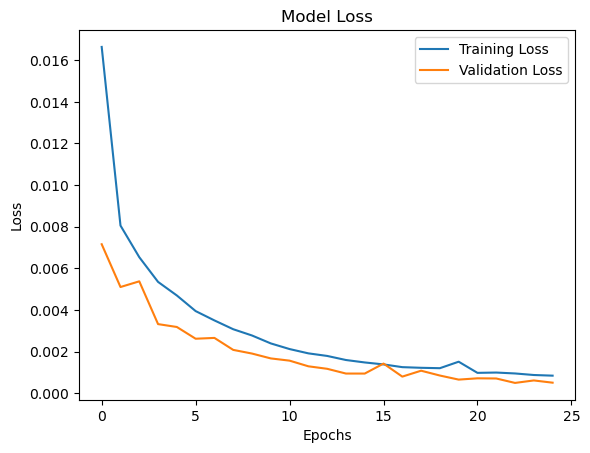

114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


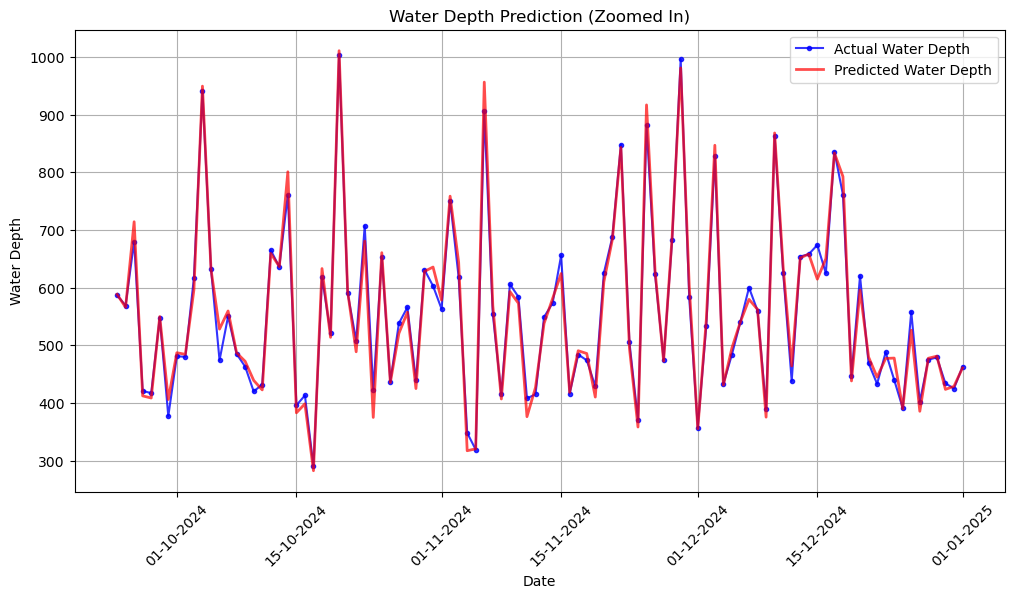

In [73]:
# Step 1: Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split

# Step 2: Load and Preprocess the Data
# Load the dataset
df = merged_data

# Display the first few rows of the dataset
print(df.head())

# Step 3: Data Preprocessing
# 3.1. Handle Missing Values (if any)
print("Missing values before handling:", df.isnull().sum())
df.ffill(inplace=True)  # Forward fill missing values
print("Missing values after handling:", df.isnull().sum())

# 3.2. Normalize the Data
feature_scaler = MinMaxScaler(feature_range=(0, 1))  # Scaler for features
target_scaler = MinMaxScaler(feature_range=(0, 1))   # Scaler for target column

# Scale features (excluding water_depth) and target separately
feature_columns = df.columns[df.columns != 'water_depth']  # All columns except target
df_scaled = feature_scaler.fit_transform(df[feature_columns])
df_target_scaled = target_scaler.fit_transform(df[['water_depth']])

# Save the scalers for future predictions
from joblib import dump
dump(feature_scaler, 'feature_scaler_dodewaard.pkl')  # Save feature scaler              ------------------------ change to Grebbe/Dodewaard
dump(target_scaler, 'target_scaler_dodewaard.pkl')    # Save target scaler               ------------------------ change to Grebbe/Dodewaard

# Combine scaled features and target
scaled_data = np.hstack((df_scaled, df_target_scaled))

# 3.3. Create Sequences for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :-1])  # All columns except the last one (features)
        y.append(data[i, -1])  # The last column (target)
    return np.array(X), np.array(y)

seq_length = 60  # Define sequence length - this is the short term memory where we dont expect patterns to repeat within the sequence length
X, y = create_sequences(scaled_data, seq_length)  # Create sequences

# 3.4. Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # change test_size and check which gives better accuracy, random_state is to introduce stochasticity - a random event into the model, does not make a difference

# Step 4: Build the LSTM Model
model = Sequential()  # Initialize the model - my model is sequential

# Add the first LSTM layer - units are 50 nodes, can be experimented with; return_sequences keeps the sequential order even after finding the pattern; 
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Add dropout to prevent overfitting

# Add a second LSTM layer - for short term memory patterns
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add a Dense output layer - rechecks the weights assigned to the independent variables, can increase the dense layers but not required?
model.add(Dense(units=1))

# Compile the model - finding the differential of the function; can also define learning rate; comparison to test data is done with mean_squared_error
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model - tells how much data is being input
model.summary()

# Step 5: Train the Model - epochs is nunmber of times the model is trained before applying test data; batch size is to limit the number of calculations per run
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test))

# Step 6: Evaluate the Model
# 6.1. Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss') # how much loss was there during training
plt.plot(history.history['val_loss'], label='Validation Loss') # how much loss was there after training
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 6.2. Make Predictions
predictions = model.predict(X_test)  # Predict on the test data

# 6.3. Inverse Transform Predictions and Actual Values
predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 6.4. Plot Predictions vs Actual Values
# Convert 'year' and 'day_of_year' into actual dates
df['date'] = df.apply(lambda row: datetime.datetime.strptime(f"{int(row['year'])}-{int(row['day_of_year'])}", "%Y-%j"), axis=1)

# Select a smaller range for better visibility
num_days_to_plot = 100
dates = df['date'].iloc[-num_days_to_plot:]  
y_actual = y_test_original[-num_days_to_plot:]
y_pred = predictions[-num_days_to_plot:]

plt.figure(figsize=(12, 6))

# Plot actual values as a thick blue line
plt.plot(dates, y_actual, 'bo-', markersize=3, label='Actual Water Depth', alpha=0.8)

# Plot predictions as a smooth red line
plt.plot(dates, y_pred, 'r-', linewidth=2, label='Predicted Water Depth', alpha=0.7)

# Formatting the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Water Depth')
plt.legend()
plt.title('Water Depth Prediction (Zoomed In)')
plt.grid(True)

plt.show()

# Step 7: Save the Model (Optional)
model.save('Dodewaard_water_depth_lstm_model.keras')  # Save the model                   ------------------- change to Grebbe/Dodewaard

### Prepare weather data (past 60 days) to predict water depth (Step 6)
__Code block function:__ This block fetches the past 60 days of weather data (from open-meteo) for the same 10 locations whose data was used to train the LSTM model. Then it rearranges the data to the exact same columns which were used to train the LSTM model. The prepared data can be input into the LSTM model to predict tomorrow's water depth at Grebbe and Dodewaard.

__Contribution to Goal 2:__ There were no new learnings from this code block because I reused the code from the previous blocks to perform this part of the data wrangling and preparation.

In [9]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from datetime import datetime, timedelta

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Function to process daily data for one location
def process_location_data(response):
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")
    
    daily = response.Daily()
    daily_data = {
        "date": pd.date_range(
            start=pd.to_datetime(daily.Time(), unit="s", utc=True),
            end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=daily.Interval()),
            inclusive="left"
        ),
        "temperature_2m_mean": daily.Variables(0).ValuesAsNumpy(),
        "daylight_duration": daily.Variables(1).ValuesAsNumpy(),
        "sunshine_duration": daily.Variables(2).ValuesAsNumpy(),
        "precipitation_sum": daily.Variables(3).ValuesAsNumpy(),
        "precipitation_hours": daily.Variables(4).ValuesAsNumpy(),
        "wind_speed_10m_max": daily.Variables(5).ValuesAsNumpy(),
        "wind_direction_10m_dominant": daily.Variables(6).ValuesAsNumpy(),
        "shortwave_radiation_sum": daily.Variables(7).ValuesAsNumpy()
    }
    return pd.DataFrame(data=daily_data)

# List of locations to fetch data for (latitude, longitude)
locations = [
    {"latitude": 47.0148862689, "longitude": 9.2490818321},  
    {"latitude": 48.0561013408, "longitude": 9.5514402618},  
    {"latitude": 47.9734825136, "longitude": 8.7353165590}, 
    {"latitude": 47.5598803131, "longitude": 7.7607424907},
    {"latitude": 47.2781227972, "longitude": 8.1218956317},
    {"latitude": 47.8954308927, "longitude": 8.3057342889},
    {"latitude": 47.9342963251, "longitude": 8.1956883139},
    {"latitude": 48.0649760121, "longitude": 8.9797479456},
    {"latitude": 47.8700339813, "longitude": 9.2892803863},
    {"latitude": 47.3828032700, "longitude": 8.1122011127}, 
]

# Make API calls and process data for all locations
all_dataframes = []

today = datetime.today().strftime('%Y-%m-%d')
sixty_days_ago = (datetime.today() - timedelta(days=60)).strftime('%Y-%m-%d')

for location in locations:
    params = {
        "latitude": location["latitude"],
        "longitude": location["longitude"],
        "start_date": sixty_days_ago,
        "end_date": today,
        "daily": [
            "temperature_2m_mean", "daylight_duration", "sunshine_duration", 
            "precipitation_sum", "precipitation_hours", "wind_speed_10m_max", 
            "wind_direction_10m_dominant", "shortwave_radiation_sum"
        ],
        "timezone": "auto"  # Automatically fetch timezone based on location
    }
    responses = openmeteo.weather_api("https://archive-api.open-meteo.com/v1/archive", params=params)
    response = responses[0]
    location_data = process_location_data(response)
    location_data["location"] = f"{location['latitude']},{location['longitude']}"  # Add location info
    all_dataframes.append(location_data)

# Combine all dataframes into one
merged_data = pd.concat(all_dataframes, ignore_index=True)

# Output the combined dataframe
print(merged_data.columns)

merged_data['new_date'] = (pd.to_datetime(merged_data['date']) + pd.Timedelta(hours=1)).dt.date

# Ensure 'new_date' is in datetime format
merged_data['new_date'] = pd.to_datetime(merged_data['new_date'])

# Extract useful date-related features
merged_data['year'] = merged_data['new_date'].dt.year
merged_data['month'] = merged_data['new_date'].dt.month  # 1 to 12
merged_data['day'] = merged_data['new_date'].dt.day  # 1 to 31
merged_data['weekday'] = merged_data['new_date'].dt.weekday  # Monday=0, Sunday=6
merged_data['day_of_year'] = merged_data['new_date'].dt.dayofyear  # 1 to 365/366

# Drop the original date column (LSTM doesn't work with raw dates)
merged_data = merged_data.drop(columns=['new_date'])

import numpy as np

# Encode cyclic features
merged_data['month_sin'] = np.sin(2 * np.pi * merged_data['month'] / 12)
merged_data['month_cos'] = np.cos(2 * np.pi * merged_data['month'] / 12)

merged_data['day_sin'] = np.sin(2 * np.pi * merged_data['day'] / 31)
merged_data['day_cos'] = np.cos(2 * np.pi * merged_data['day'] / 31)

merged_data['weekday_sin'] = np.sin(2 * np.pi * merged_data['weekday'] / 7)
merged_data['weekday_cos'] = np.cos(2 * np.pi * merged_data['weekday'] / 7)

merged_data[['latitude', 'longitude']] = (merged_data['location'].str.split(',', expand=True)).astype(float)

# Drop unnecessary columns
merged_data = merged_data.drop(columns=['month', 'day', 'weekday','date','location'])

print(merged_data.columns)
print(merged_data.dtypes)

Coordinates 46.99472427368164°N 9.204545021057129°E
Elevation 2151.0 m asl
Timezone b'Europe/Zurich' b'GMT+1'
Timezone difference to GMT+0 3600 s
Coordinates 48.0492057800293°N 9.584026336669922°E
Elevation 605.0 m asl
Timezone b'Europe/Berlin' b'GMT+1'
Timezone difference to GMT+0 3600 s
Coordinates 47.97890853881836°N 8.820598602294922°E
Elevation 880.0 m asl
Timezone b'Europe/Berlin' b'GMT+1'
Timezone difference to GMT+0 3600 s
Coordinates 47.5571174621582°N 7.697368621826172°E
Elevation 279.0 m asl
Timezone b'Europe/Berlin' b'GMT+1'
Timezone difference to GMT+0 3600 s
Coordinates 47.27592086791992°N 8.235294342041016°E
Elevation 687.0 m asl
Timezone b'Europe/Zurich' b'GMT+1'
Timezone difference to GMT+0 3600 s
Coordinates 47.90861129760742°N 8.358208656311035°E
Elevation 841.0 m asl
Timezone b'Europe/Berlin' b'GMT+1'
Timezone difference to GMT+0 3600 s
Coordinates 47.90861129760742°N 8.358208656311035°E
Elevation 859.0 m asl
Timezone b'Europe/Berlin' b'GMT+1'
Timezone difference to

### Running the Long short-term memory (LSTM) model to predict water depth (Step 6)
__Code block function:__ This code block feeds the past 60 days of weather data into the two LSTM models and returns the water depth at Grebbe and at Dodewaard.

__Contribution to Goal 2:__ Since I had never run an LSTM before, I did not know how to implement this code. I used the help of chatgpt to produce this code, debug it and specifically use it for my purpose. I understood that the scaled values of the weather data are passed as inputs to the models and the model returns the scaled output of water depth, which is inverse scaled to return the water depths.

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from joblib import load

# Load the models and scalers
model_grebbe = load_model('Grebbe_water_depth_lstm_model.keras')
feature_scaler_grebbe = load('feature_scaler_grebbe.pkl')
target_scaler_grebbe = load('target_scaler_grebbe.pkl')

model_dodewaard = load_model('Dodewaard_water_depth_lstm_model.keras')
feature_scaler_dodewaard = load('feature_scaler_dodewaard.pkl')
target_scaler_dodewaard = load('target_scaler_dodewaard.pkl')

# Load new weather data
new_data = merged_data

# Preprocess new data
new_data.ffill(inplace=True)  # Forward fill missing values

# Scale features for both models
scaled_features_grebbe = feature_scaler_grebbe.transform(new_data)
scaled_features_dodewaard = feature_scaler_dodewaard.transform(new_data)

# Create input sequences
def create_input_sequence(scaled_features, seq_length=60):
    return scaled_features[-seq_length:].reshape(1, seq_length, -1)

input_sequence_grebbe = create_input_sequence(scaled_features_grebbe)
input_sequence_dodewaard = create_input_sequence(scaled_features_dodewaard)

# Define a prediction function with reduce_retracing
@tf.function(reduce_retracing=True)
def predict_function(model, inputs):
    return model(inputs)

# Predict with Grebbe model
predicted_scaled_grebbe = predict_function(model_grebbe, input_sequence_grebbe)
predicted_water_depth_grebbe = target_scaler_grebbe.inverse_transform(predicted_scaled_grebbe)
print(f"Predicted Water Depth (Grebbe): {predicted_water_depth_grebbe[0][0]}")

# Predict with Dodewaard model
predicted_scaled_dodewaard = predict_function(model_dodewaard, input_sequence_dodewaard)
predicted_water_depth_dodewaard = target_scaler_dodewaard.inverse_transform(predicted_scaled_dodewaard)
print(f"Predicted Water Depth (Dodewaard): {predicted_water_depth_dodewaard[0][0]}")

Predicted Water Depth (Grebbe): 666.1873917579651
Predicted Water Depth (Dodewaard): 853.997682571411


### Visualisation of predicted water depth (Step 7)
__Code block function:__ This code block creates an interactive map where we can see the predicted water depths in both the locations. If we click on the location marker, it displays the scale (which shows the risk of the depth). The design is similar to the design followed by rijkswaterstaat website (https://waterinfo.rws.nl/).

__Contribution to Goal 1 and 3:__ I had never used folium before and had to learn the syntax to create a map and display the coordinates. Beyond the basic visualisation of the map, I learnt how to dynamically change the colour of the icons, how to display the scale (specific to the location) as the popup and how to add elements to the map (such as title, markers and legend - which is not there in this map). For learning the syntax specific to this project, I again used the help of chatgpt.

In [13]:
import folium
from folium.plugins import FloatImage
from branca.element import Template, MacroElement

# Define coordinates for the two locations
grebbe_coords = [51.949326, 5.590224]  # Replace with Grebbe's actual coordinates
dodewaard_coords = [51.900851, 5.630828]  # Replace with Dodewaard's actual coordinates

# Predicted water depths (replace with your actual predictions)
predicted_water_depth_grebbe = round(predicted_water_depth_grebbe[0][0])  
predicted_water_depth_dodewaard = round(predicted_water_depth_dodewaard[0][0])

# Define a color scale for water depths
def get_color_grebbe(water_depth):
    if water_depth < 585:
        return 'brown'  # Low
    elif 586 <= water_depth < 685:
        return 'green'  # Normal
    elif 686 <= water_depth < 750:
        return 'lightgreen'  # Slightly raised
    elif 751 <= water_depth < 905:
        return 'yellow'  # Elevated
    elif 906 <= water_depth < 1025:
        return 'orange'  # High
    else:
        return 'red'  # Extremely high

def get_color_dodewaard(water_depth):
    if water_depth < 365:
        return 'brown'  # Low
    elif 366 <= water_depth < 815:
        return 'green'  # Normal
    elif 816 <= water_depth < 890:
        return 'lightgreen'  # Slightly raised
    elif 891 <= water_depth < 1030:
        return 'yellow'  # Elevated
    elif 1031 <= water_depth < 1130:
        return 'orange'  # High
    else:
        return 'red'  # Extremely high

# Define custom scales for each location
grebbe_scale = {
    "Low": "< 585cm",
    "Normal": "586 - 685cm",
    "Slightly raised": "686 - 750cm",
    "Elevated": "751 - 905cm",
    "High": "906 - 1025cm",
    "Extremely high": "> 1025cm"
}

dodewaard_scale = {
    "Low": "< 364cm",
    "Normal": "366 - 815cm",
    "Slightly raised": "816 - 890cm",
    "Elevated": "891 - 1030cm",
    "High": "1031 - 1130cm",
    "Extremely high": "> 1130cm"
}

# Function to generate scale HTML for popup (styled like a legend)
def generate_scale_html(scale, title):
    html = f"""
    <div style="font-family: Arial, sans-serif; padding: 10px; background-color: white; border-radius: 5px; box-shadow: 0 0 5px rgba(0,0,0,0.3);">
        <h4 style="margin: 0 0 10px; font-size: 14px;">{title}</h4>
        <table style="width: 100%; border-collapse: collapse;">
    """
    for level, range in scale.items():
        html += f"""
        <tr>
            <td style="padding: 5px; border-bottom: 1px solid #ddd;">
                <span style="display: inline-block; width: 12px; height: 12px; background-color: {get_color_grebbe(584 if level == "Low" else 587 if level == "Normal" else 687 if level == "Slightly raised" else 752 if level == "Elevated" else 907 if level == "High" else 1026)}; margin-right: 8px;"></span>
                <b>{level}</b>: {range}
            </td>
        </tr>
        """
    html += """
        </table>
    </div>
    """
    return html

# Create a map centered between the two locations
map_center = [(grebbe_coords[0] + dodewaard_coords[0]) / 2, (grebbe_coords[1] + dodewaard_coords[1]) / 2]
mymap = folium.Map(location=map_center, zoom_start=12)

title_html = '''
    <h1 style="
        position: fixed;
        top: 10px;
        left: 50%;
        transform: translateX(-50%);
        z-index: 1000;
        background-color: rgba(255, 255, 255, 0.8);
        padding: 10px;
        border-radius: 5px;
        border: 1px solid #ccc;
        box-shadow: 2px 2px 4px rgba(0, 0, 0, 0.2);
        font-family: Arial, sans-serif;
        font-weight: bold
        font-size: 16px;
        text-align: center;
    ">
        Water Depth Prediction Map
    </h3>
'''
mymap.get_root().html.add_child(folium.Element(title_html))

# Add markers for Grebbe
folium.Marker(
    location=grebbe_coords,
    popup=folium.Popup(generate_scale_html(grebbe_scale, "Grebbe Water Depth Scale"), max_width=300),
    tooltip=f"Grebbe: {predicted_water_depth_grebbe} cm",
    icon=folium.Icon(color=get_color_grebbe(predicted_water_depth_grebbe), icon='tint', prefix='fa')
).add_to(mymap)

# Add text label for Grebbe marker
folium.Marker(
    location=grebbe_coords,
    icon=folium.DivIcon(
        html=f'''
        <div style="
            font-size: 10pt; 
            color: black; 
            font-weight: bold; 
            background-color: rgba(255, 255, 255, 0.8); 
            padding: 4px 15px; 
            border-radius: 4px; 
            border: 1px solid #ccc; 
            box-shadow: 2px 2px 4px rgba(0, 0, 0, 0.2);
            width: fit-content; 
        ">
            {predicted_water_depth_grebbe} cm
        </div>
        '''
    )
).add_to(mymap)

# Add markers for Dodewaard
folium.Marker(
    location=dodewaard_coords,
    popup=folium.Popup(generate_scale_html(dodewaard_scale, "Dodewaard Water Depth Scale"), max_width=300),
    tooltip=f"Dodewaard: {predicted_water_depth_dodewaard} cm",
    icon=folium.Icon(color=get_color_dodewaard(predicted_water_depth_dodewaard), icon='tint', prefix='fa')
).add_to(mymap)

# Add text label for Dodewaard marker
folium.Marker(
    location=dodewaard_coords,
    icon=folium.DivIcon(
        html=f'''
        <div style="
            font-size: 10pt; 
            color: black; 
            font-weight: bold; 
            background-color: rgba(255, 255, 255, 0.8); 
            padding: 4px 15px; 
            border-radius: 4px; 
            border: 1px solid #ccc; 
            box-shadow: 2px 2px 4px rgba(0, 0, 0, 0.2);
            width: fit-content;
        ">
            {predicted_water_depth_dodewaard} cm
        </div>
        '''
    )
).add_to(mymap)

# Save the map to an HTML file
mymap.save("water_depth_map.html")

# Display the map in a Jupyter Notebook (if using Jupyter)
mymap

## Unused methods (but learnt something new)

### Obtain latest folder from Harmonie model harmonie_arome_cy43_p3
__Code block function:__ This code block acquires the latest folder from the knmi harmonie model API, downloads it into the mentioned directory and unzips the files.

__Contribution to Goal 2:__ I obtained the base code from the developer website for harmonie (https://developer.dataplatform.knmi.nl/open-data-api#example-last). However, I had to make some changes to it such that it extracts the files of the latest folder into a folder which has a time-dependent variable name. Understanding the code helped me understand how we can interact with the api and its responses using Python. I learnt that the response is usually an object and its components can be referred to like a multi-dimensional array. For example: objectname[0][0].

In [62]:
import logging
import os
import sys
import tarfile
import requests
from datetime import datetime

# Get today's date in yyyymmdd format - for assigning the time-dependent variable name for the folder
now = datetime.now().strftime("%Y%m%d%H")

logging.basicConfig()
logger = logging.getLogger(__name__)
logger.setLevel(os.environ.get("LOG_LEVEL", logging.INFO))


class OpenDataAPI:
    def __init__(self, api_token: str):
        self.base_url = "https://api.dataplatform.knmi.nl/open-data/v1"
        self.headers = {"Authorization": api_token}

    def __get_data(self, url, params=None):
        return requests.get(url, headers=self.headers, params=params).json()

    def list_files(self, dataset_name: str, dataset_version: str, params: dict):
        return self.__get_data(
            f"{self.base_url}/datasets/{dataset_name}/versions/{dataset_version}/files",
            params=params,
        )

    def get_file_url(self, dataset_name: str, dataset_version: str, file_name: str):
        return self.__get_data(
            f"{self.base_url}/datasets/{dataset_name}/versions/{dataset_version}/files/{file_name}/url"
        )


def download_file_from_temporary_download_url(download_url, filename):
    try:
        with requests.get(download_url, stream=True) as r:
            r.raise_for_status()
            with open(filename, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
    except Exception:
        logger.exception("Unable to download file using download URL")
        sys.exit(1)

    logger.info(f"Successfully downloaded dataset file to {filename}")


def main(): # check if the api_key still works. If expired, it can be changed from developer website: https://developer.dataplatform.knmi.nl/open-data-api#token
    api_key = "eyJvcmciOiI1ZTU1NGUxOTI3NGE5NjAwMDEyYTNlYjEiLCJpZCI6ImE1OGI5NGZmMDY5NDRhZDNhZjFkMDBmNDBmNTQyNjBkIiwiaCI6Im11cm11cjEyOCJ9" 
    dataset_name = "harmonie_arome_cy43_p1"
    dataset_version = "1.0"
    logger.info(f"Fetching latest file of {dataset_name} version {dataset_version}")

    api = OpenDataAPI(api_token=api_key)

    # sort the files in descending order and only retrieve the first file
    params = {"maxKeys": 1, "orderBy": "created", "sorting": "desc"}
    response = api.list_files(dataset_name, dataset_version, params)
    if "error" in response:
        logger.error(f"Unable to retrieve list of files: {response['error']}")
        sys.exit(1)

    #print(response)
    
    latest_file = response["files"][0].get("filename")
    logger.info(f"Latest file is: {latest_file}")

    # fetch the download url and download the file
    response = api.get_file_url(dataset_name, dataset_version, latest_file)
    download_file_from_temporary_download_url(response["temporaryDownloadUrl"], latest_file)

    # Open the .tar file
    global latest_folder
    latest_folder = f"{now}_extracted"                            # this is the time-dependent folder name into which the files will be extracted
    with tarfile.open('/Users/niksh/Downloads/'+latest_file, "r") as tar:
    # Extract all contents to the required directory
        tar.extractall(path="/Users/niksh/Downloads/"+latest_folder)
    logger.info(f"{latest_file} has been extracted into {latest_folder}")
    

if __name__ == "__main__":
    main()

INFO:__main__:Fetching latest file of harmonie_arome_cy43_p1 version 1.0
INFO:__main__:Latest file is: HARM43_V1_P1_2025013113.tar
INFO:__main__:Successfully downloaded dataset file to HARM43_V1_P1_2025013113.tar
INFO:__main__:HARM43_V1_P1_2025013113.tar has been extracted into 2025013117_extracted


### Wrangle and rearrange GRIB data
__Code block function:__ This code block fetches the last file (60th hour prediction of weather), uses pygrib to open the gridded data, acquires the relevant "messages" from the grib file - in this case it is the 43rd and 42nd messages, and converts it into a pandas dataframe.

__Contribution to Goal 2:__ For many days, I struggled to understand how to interpret or interact with GRIB data. Finally, another group's member (Aditi) helped me in understanding how pygrib library works and how grib files are divided as messages. Each message is just an object and can be referred to like an array - for example: grbs[42]. I used chatgpt to learn the syntax to match the latitudes and longitudes with the respective precipitation and snow values. This was the first time I rearranged GRIB data into a useable dataframe. I also learnt how to open a GRIB file using Panoply software (thanks to Aditi again).

In [64]:
import xarray as xr
import matplotlib.pyplot as plt
import pygrib as pygrib
import pandas as pd
import os

# Path to your GRIB file
grib_folder = f"/Users/niksh/Downloads/{latest_folder}"
grib_files = os.listdir(grib_folder)
grib_file = os.path.join(grib_folder, max(grib_files))

# Open a GRIB file
grbs = pygrib.open(grib_file)

#get the messages of parameter 61 (precipitation) and 66 (snow)
precip = grbs[43]
snow = grbs[42]
print(precip)
print(snow)
print(" ")

#get latitudes, longitudes and the values of precipitation / snow depth as arrays
lats = grbs[43].latlons()[0]
longs = grbs[43].latlons()[1]
precipArray = precip.values
snowArray = snow.values

#convert everything to dataframes
df_lats = pd.DataFrame(lats)
df_longs = pd.DataFrame(longs)
df_precip = pd.DataFrame(precipArray)
df_snow = pd.DataFrame(snowArray)

df_combined = pd.DataFrame({
    'Latitude': df_lats.values.flatten(),
    'Longitude': df_longs.values.flatten(),
    'Precipitation': df_precip.values.flatten(),
    'Snow': df_snow.values.flatten()
})

print(df_combined)

43:61:61 (accum):regular_ll:heightAboveGround:level 0:fcst time 0-60 hrs (accum):from 202501311300
42:66:66 (instant):regular_ll:heightAboveGround:level 0:fcst time 60 hrs:from 202501311300
 
        Latitude  Longitude  Precipitation  Snow
0         49.000      0.000       1.949314   0.0
1         49.000      0.029       1.436779   0.0
2         49.000      0.058       1.096489   0.0
3         49.000      0.087       1.004065   0.0
4         49.000      0.116       1.083886   0.0
...          ...        ...            ...   ...
152095    56.002     11.165       0.699021   NaN
152096    56.002     11.194       0.535178   NaN
152097    56.002     11.223       0.532436   NaN
152098    56.002     11.252       0.528235   NaN
152099    56.002     11.281       0.536637   0.0

[152100 rows x 4 columns]


## Conclusions on Results

- The water depth in the Betuwe region of Netherlands can be predicted using an LSTM model which uses inputs of weather from 10 locations in the Swiss alps where the river Rhine is born.
- With the given parameters used in the LSTM model, the validation loss in the last epoch of the LSTM model is about 0.0005. It is probably possible to reduce it further by playing around with the parameters.
- For predicting hourly values using the same method, more computational power may be required. It might be easier to use a more efficient machine learning model.
- GRIB data is difficult to interact with but with the pygrib library, it is easy.

## Conclusions on accomplishment of goals

__Goal 1: Data Visualization__ 

It was fairly easy to understand folium library on Python and create an interactive visualisation of the map showing water depth in the two locations. I can imagine it to be more complicated if we have to show dynamic graphs like the Rijkswaterstaat website. I successfully produced the Python script for an interactive map.

__Goal 2: Advanced Spatial Data Handling__ 

This took a lot more time and effort than I anticipated. Although I was not able to use the GRIB data to do the analyses (because harmonie model does not archive past data), I learnt a lot about LSTMs - the mechanism of their working, the ways to prepare data for them (especially dates as cyclic features) and evaluating their performance. I successfully produced the Python script for analysing weather data and water depth data to generate a spatially dependent trained LSTM model.

__Goal 3: Effective Communication of Uncertainty__ 

The predicted water depth data was presented on the map as objectively as possible. There were no flood warnings because the water depth was sometimes 100 cm above or below the actual depth. Instead a range scale (taken from the Rijkswaterstaat website) was included to indicate the "seriousness" of the water depth in the location. 
The decision taken for visualisations was based on the following __reflections on the societal impact of uncertainty__:
1. The model only predicts the water depth and not the flood risk to the region. The risk of flood is dependent on other factors including dikes and other protections to the buildings. So it is not correct to show a flood warning based on the predicted water depth.
2. Furthermore, the model predicts water depths with about 9 decimal points. However, the validation loss is about 0.0005 which means the precision cannot be higher than 2 decimal points. For the visualisation of the depth, it makes sense to round it to the nearest integer so as to not give a false sense of certainty.
3. Displaying the scale which decides the color of "seriousness" will allow the user to see how high the value is in a particular range bin and then further evaluate the "seriousness" based on it. For example, 751 to 906 can be "High" and have the color red. However, if the actual predicted value is 752, it is possible that the value is overestimated into a new range bin. The user can realise this by looking at the scale. However, if the predicted value is around 890, then it is potentially in the same range bin and needs to be considered "High".